# Temporal and spatial analysis of the characteristics of well-performing movies

## Table of Contents
* [Load the data](#chapter1)
* [Exploratory data analysis](#chapter2)
    * [Distribution of the data](#section_2_4)
        * [Languages](#sub_section_2_4_1)
        * [Countries](#sub_section_2_4_2)
        * [Genres](#sub_section_2_4_3)
        * [Release date](#sub_section_2_4_4)
        * [Runtime](#sub_section_2_4_5)
        * [Movie name](#sub_section_2_4_6)
* [Merge CMU dataset with IMDb dataset](#chapter3)
    * [Getting the matching Freebase ID and IMDb ID](#section_3_1)
    * [Merging CMU dataset and IMDb dataset](#section_3_2)
* [Compute correlation beteen two categorical variables](#chapter4)
    * [Function definitions](#section_4_1)
        * [Format the data](#sub_section_4_1_1)
        * [Compute the p-value for the H0: "var1 and var2 are independent"](#sub_section_2_3_1)
    * [P-value computations](#section_4_2)
        * [Languages vs Countries](#sub_section_4_2_1)
        * [Languages vs Genres](#sub_section_4_2_2)
        * [Countries vs Genres](#sub_section_4_2_3)

In [7]:
import numpy as np
import pandas as pd
import ast
import scipy.stats as ss

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pylab as pl

import itertools
import unidecode
from collections import Counter

import os

import requests

'''Download the files from the following folder and place them under datasets/moviedata/
https://drive.google.com/drive/folders/1mJsTvP3VfzLWgV_zlO1S9xiWyrTJlNG4?usp=sharing
'''

PATH_IN = './datasets/moviedata/'

In [8]:
'''Load the data from the saved reformatted dataset "formatted_movie_metadata.csv"'''
fname = os.path.join(PATH_IN, 'formatted_movie_metadata.csv')
df = pd.read_csv(fname)

# Remove the '-' from the release date
# eg convert 2007-09-14 to 20070914
df['Release date'] = [''.join(x.split('-')) if pd.isna(x)==False else x for x in df['Release date']]

# Convert string of a list, to a list
# eg convert '['English', 'French']' to ['English', 'French']
df['Languages'] = df['Languages'].apply(lambda x: ast.literal_eval(x))
df['Countries'] = df['Countries'].apply(lambda x: ast.literal_eval(x))
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x))

### d) Distribution of the data <a class="anchor" id="section_2_4"></a>

In [9]:
def categorical_var_histogram(var_name):
    '''Histogram of the 10 most frequent values for the categorical variables'''
    
    # Concatenate all elements of the dataseries to obtain a single list (instead of a list of list)
    var_list = list(itertools.chain.from_iterable(df[var_name]))

    # Compute the number of occurences of each values
    # (-> dictionnary containing values and associated number of occurences)
    frequencies = Counter(var_list)

    # Sort by most frequent values
    frequencies = [[key, int(val)] for key, val in frequencies.items()]
    frequencies.sort(key=lambda x: -x[1])

    # Compute the number of entries corresponding to the 10 most frequent values
    num_entries = sum(x[1] for x in frequencies[:10])

    # Select the entries corresponding to the 10 most frequent values
    var_list.sort(key=Counter(var_list).get, reverse=True)
    var_list = pd.Series(var_list[:num_entries])

    # Plot the histogram with the y-axis in log-scale
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    hist = var_list.value_counts().plot(kind='bar', color=default_colors[:10])
    pl.xlabel(var_name, fontsize=15)
    pl.xticks(fontsize=12)
    pl.ylabel("Number of occurences", fontsize=15)
    pl.yticks(fontsize=12)
    pl.yscale('log')
    pl.title(f'Bar plot of the 10 most frequent {var_name.lower()}', fontsize=15)
    plt.show()
    
    return frequencies

In [10]:
'''Alternative to the histogram: pie chart'''

def categorical_var_piechart(frequencies):
    
    # Format the ratio displayed inside the chart
    def autopct_format(x):
        return f'{int(x)}%'

    labels = np.array(frequencies)[:,0]
    sizes = np.array(frequencies)[:,1].astype(int)

    # Group less frequent values together
    other_label = 'Other'
    other_size = np.sum(sizes[12:])

    reduced_labels = np.append(labels[:12], other_label)
    reduced_sizes = np.append(sizes[:12], other_size)

    # Plot the pie chart
    plt.figure(figsize=(9,9))
    plt.pie(reduced_sizes, labels=reduced_labels, autopct=lambda x: autopct_format(x))
    plt.show()

#### `Languages` <a class="anchor" id="sub_section_2_4_1"></a>

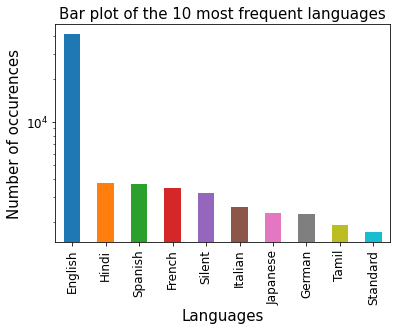

In [11]:
freq_languages = categorical_var_histogram('Languages')

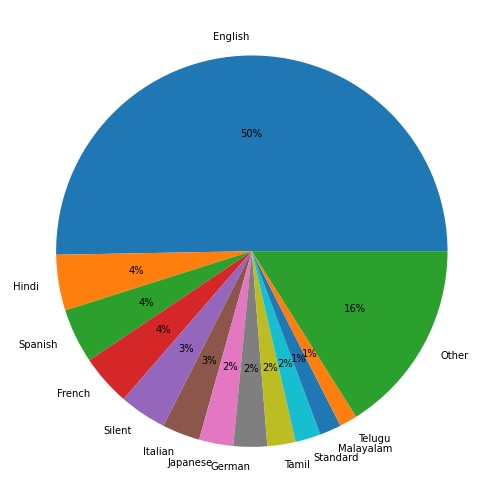

In [12]:
categorical_var_piechart(freq_languages)

#### `Countries` <a class="anchor" id="sub_section_2_4_2"></a>

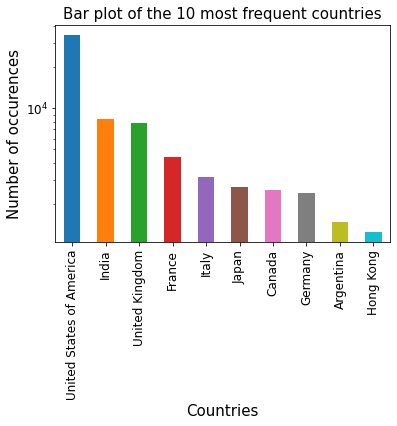

In [13]:
freq_countries = categorical_var_histogram('Countries')

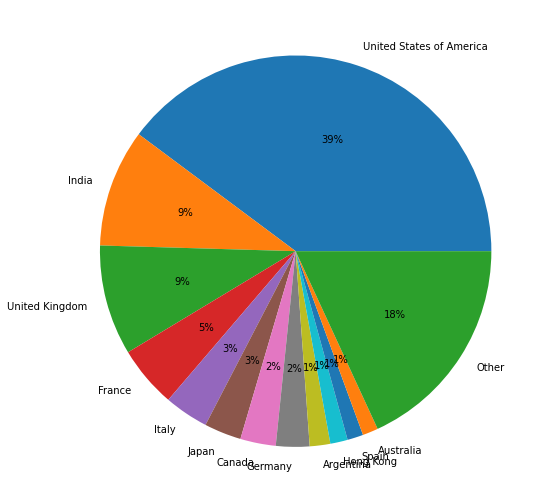

In [14]:
categorical_var_piechart(freq_countries)

#### `Genres` <a class="anchor" id="sub_section_2_4_3"></a>

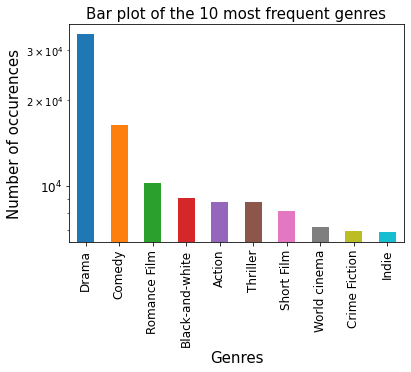

In [15]:
freq_genres = categorical_var_histogram('Genres')

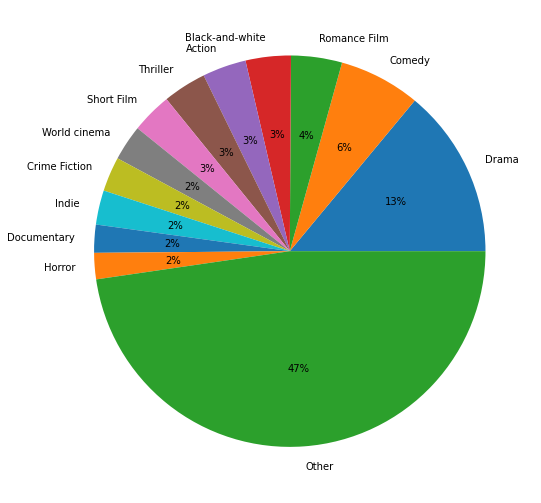

In [16]:
categorical_var_piechart(freq_genres)

#### `Release date` <a class="anchor" id="sub_section_2_4_4"></a>

In [59]:
'''Extract the year from the release date'''
df_date = df.copy()
df['Release date'].str[:4]

0        2001
1        2000
2        1988
3        1987
4        1983
         ... 
81736    2011
81737    2011
81738    1972
81739    1992
81740    2002
Name: Release date, Length: 81741, dtype: object

In [60]:
'''Convert string to int'''

# Remove the Nan values
df_date = df_date[pd.isna(df_date['Release date'])==False]

df_date['Release year'] = df_date['Release date'].str[:4]


df_date['Release date'] = df_date['Release date'].astype(int)


In [61]:
df_date

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres,Release year
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama],1983
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,20110319,120.0,[English],[United States of America],[Drama],2011
81737,34980460,/m/0g4pl34,Knuckle,20110121,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011
81738,9971909,/m/02pygw1,Another Nice Mess,19720922,66.0,[English],[United States of America],"[Satire, Comedy]",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,19920521,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992


In [62]:
'''Compute the range of the values'''
print(f"The oldest movie from the dataset was released in {df_date['Release year'].min()}.")
print(f"The more recent movie from the dataset was released in {df_date['Release year'].max()}.")

The oldest movie from the dataset was released in 1010.
The more recent movie from the dataset was released in 2016.


In [63]:
groupby_year = df_date.groupby('Release year').count()

In [64]:
groupby_year

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres
Release year,,,,,,,,
1010,1,1,1,1,1,1,1,1
1888,1,1,1,1,1,1,1,1
1889,1,1,1,1,0,1,1,1
1890,2,2,2,2,0,2,2,2
1891,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
2012,1194,1194,1194,1194,610,1194,1194,1194
2013,164,164,164,164,21,164,164,164
2014,17,17,17,17,0,17,17,17


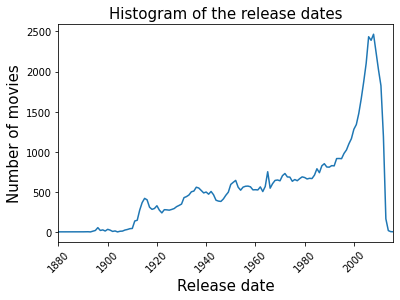

In [65]:
'''Plot the histogram'''
hist = plt.plot(groupby_year['Wikipedia ID'].index.astype(int), groupby_year['Wikipedia ID'])
plt.xlabel("Release date", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.xlim(1880, 2016)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.title('Histogram of the release dates', fontsize=15)
plt.show()

#### `Runtime` <a class="anchor" id="sub_section_2_4_5"></a>

In [66]:
df['Runtime'].head(3)

0    98.0
1    95.0
2    83.0
Name: Runtime, dtype: float64

In [67]:
'''Remove the Nan values'''
df_runtime = df['Runtime'][pd.isna(df['Runtime'])==False]

In [68]:
'''Compute the range of the values'''
print(f'The shortes movie from the dataset lasts {int(df_runtime.min())} minutes.')
print(f'The longuest movie from the dataset lasts {int(df_runtime.max())} minutes.')

The shortes movie from the dataset lasts 0 minutes.
The longuest movie from the dataset lasts 1079281 minutes.


<function matplotlib.pyplot.show(close=None, block=None)>

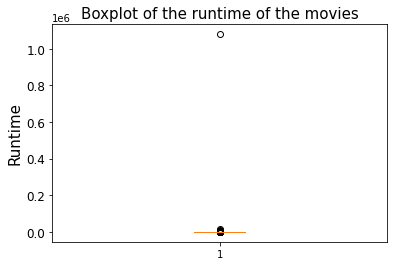

In [69]:
plt.figure(figsize=(6,4))
plt.boxplot(df_runtime)
plt.ylabel('Runtime', fontsize=15)
plt.yticks(fontsize=12)
plt.title('Boxplot of the runtime of the movies', fontsize=15)
plt.show

We observe an outlier. Assuming that runtimes over 5h (300min) are invalid, we decide to remove them.

In [70]:
df

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,20110319,120.0,[English],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,20110121,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,19720922,66.0,[English],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,19920521,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [71]:
'''Remove outliers/extreme values'''
df_runtime = df_runtime[df_runtime<300]

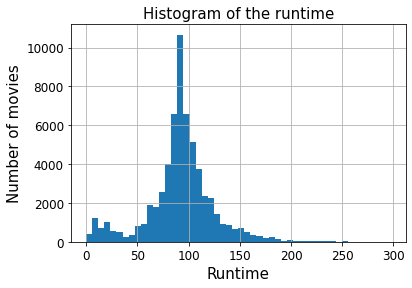

In [72]:
'''Plot the histogram'''
hist_runtime = df_runtime.hist(figsize=(6,4), bins=50)
pl.xlabel("Runtime", fontsize=15)
pl.xticks(fontsize=12)
pl.ylabel("Number of movies", fontsize=15)
pl.yticks(fontsize=12)
pl.title('Histogram of the runtime', fontsize=15)
plt.show()

#### `Movie name` <a class="anchor" id="sub_section_2_4_6"></a>

In [73]:
df['Name'].value_counts()

Alice in Wonderland        17
Macbeth                    16
A Christmas Carol          13
Les Misérables             13
Hero                       12
                           ..
Süpermenler                 1
Enakkoru Magan Pirappan     1
Los Dioses ajenos           1
28 Days Later               1
Any Number Can Play         1
Name: Name, Length: 75478, dtype: int64

There are 75478 unique names among the 81741 movie titles. We can see that some movies have the same name, thus the `names` can not be used as identifiers of movies.

In [74]:
df[['Name', 'Release date']].value_counts()

Name                             Release date
Sangam                           19640000        2
Jeepers Creepers                 19390000        2
Durango                          19990425        2
Buck Rogers in the 25th Century  19790330        2
The Job                          20030000        2
                                                ..
Hideaway                         19950303        1
Hide-Out                         19340000        1
Hide and go shriek               19880000        1
Hide and Shriek                  19380618        1
春田花花同學會                          20060126        1
Length: 74803, dtype: int64

Movies are not even uniquely defined by their (movie name, release date). Two movies can have the same name AND release date.

## 3. Merge CMU dataset with IMDB dataset <a class="anchor" id="chapter3"></a>

### a) Getting the matching Freebase ID and IMDb ID <a class="anchor" id="section_3_1"></a>

From the exploratory data analysis, we concluded that we could not merge the CMU dataset with the IMDb dataset based on the titles or the release dates of the movies as they do not uniquely define them.

Thus, we make use of Wikidata Query Service in order to get matching Freebase ID with IMDb ID.

We used the following query:

https://query.wikidata.org/#PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%3Fitem%20%3FfreebaseID%20%3FimdbID%0AWHERE%20%7B%0A%20%20%3Fitem%20wdt%3AP31%2Fwdt%3AP279%2a%20wd%3AQ11424.%0A%20%20%3Fitem%20wdt%3AP646%20%3FfreebaseID.%0A%20%20%3Fitem%20wdt%3AP345%20%3FimdbID.%0A%20%20%7D

where
* **P646**: identifier for a page in the `Freebase` database (format: "/m/0" followed by 2 to 7 characters)
* **P345**: identifier for the `IMDb` (with prefix 'tt', 'nm', 'co', 'ev', 'ch' or 'ni')

### b) Merging CMU dataset and IMDb dataset <a class="anchor" id="section_3_2"></a>

In [76]:
"""
The files are officially published by IMDB and were downloaded from: https://datasets.imdbws.com/
more info can be read here: https://www.imdb.com/interfaces/
"""

movie_names = pd.read_csv(PATH_IN + 'title.basics.tsv', sep='\t')
movie_ratings = pd.read_csv(PATH_IN + 'title.ratings.tsv', sep='\t')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
# movie_ratings.head()
# movie_names[movie_names['tconst'] == 'tt0200545']
movie_names.info()
movie_ratings.info()

In [77]:
def format_title(title):
    return unidecode.unidecode(title).lower()

In [78]:
imdb_movies = pd.merge(movie_names, movie_ratings, on='tconst')

In [79]:
imdb_movies.info()
imdb_movies = imdb_movies.rename(columns={"primaryTitle": "name", "startYear": "release_date", "runtimeMinutes": "runtime"})

imdb_movies["name"] = imdb_movies["name"].apply(lambda x: format_title(x))
imdb_movies["release_date"] = imdb_movies["release_date"].fillna(0).apply(lambda x: 0 if x == '\\N' else float(x)).astype('Int64')
imdb_movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246402 entries, 0 to 1246401
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tconst          1246402 non-null  object 
 1   titleType       1246402 non-null  object 
 2   primaryTitle    1246402 non-null  object 
 3   originalTitle   1246402 non-null  object 
 4   isAdult         1246402 non-null  object 
 5   startYear       1246402 non-null  object 
 6   endYear         1246402 non-null  object 
 7   runtimeMinutes  1246402 non-null  object 
 8   genres          1246400 non-null  object 
 9   averageRating   1246402 non-null  float64
 10  numVotes        1246402 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 114.1+ MB


,tconst,titleType,name,originalTitle,isAdult,release_date,endYear,runtime,genres,averageRating,numVotes
0,tt0000001,short,carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1922
1,tt0000002,short,le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",5.8,259
2,tt0000003,short,pauvre pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1734
3,tt0000004,short,un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",5.6,174
4,tt0000005,short,blacksmith scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2545


In [81]:
cmu_movies = pd.read_csv(PATH_IN + 'movie.metadata.tsv', sep='\t', header=None,
                names=[
                    "wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries","genres",
                ],)

cmu_movies["release_date"] = cmu_movies["release_date"].fillna(0).apply(lambda x: int(float(str(x)[:4])))
cmu_movies["name"] = cmu_movies["name"].apply(lambda x: format_title(x))
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_id       81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  81741 non-null  int64  
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [82]:
pd_merged = pd.merge(cmu_movies, imdb_movies, on=["name", "release_date"])
pd_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52856 entries, 0 to 52855
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wiki_id        52856 non-null  int64  
 1   freebase_id    52856 non-null  object 
 2   name           52856 non-null  object 
 3   release_date   52856 non-null  int64  
 4   revenue        8368 non-null   float64
 5   runtime_x      44482 non-null  float64
 6   languages      52856 non-null  object 
 7   countries      52856 non-null  object 
 8   genres_x       52856 non-null  object 
 9   tconst         52856 non-null  object 
 10  titleType      52856 non-null  object 
 11  originalTitle  52856 non-null  object 
 12  isAdult        52856 non-null  object 
 13  endYear        52856 non-null  object 
 14  runtime_y      52856 non-null  object 
 15  genres_y       52856 non-null  object 
 16  averageRating  52856 non-null  float64
 17  numVotes       52856 non-null  int64  
dtypes: flo

In [83]:
pd_merged['titleType'].unique()

array(['movie', 'tvEpisode', 'tvMovie', 'short', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvShort', 'tvSpecial'], dtype=object)

In [84]:
imdb_movies[imdb_movies['tconst'] == 'tt0200545']

,tconst,titleType,name,originalTitle,isAdult,release_date,endYear,runtime,genres,averageRating,numVotes


In [85]:
imdb_movies[imdb_movies['tconst'] == 'tt0245916']

,tconst,titleType,name,originalTitle,isAdult,release_date,endYear,runtime,genres,averageRating,numVotes
150653,tt0245916,tvMovie,getting away with murder: the jonbenet ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,0,2000,\N,95,Drama,5.9,66


In [86]:
cmu_movies[cmu_movies['name'] == "White Of The Eye"]

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres


In [87]:
pd_merged.head(20)

,wiki_id,freebase_id,name,release_date,revenue,runtime_x,languages,countries,genres_x,tconst,titleType,originalTitle,isAdult,endYear,runtime_y,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,movie,Ghosts of Mars,0,\N,98,"Action,Horror,Sci-Fi",4.9,55240
1,975900,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0594845,tvEpisode,Ghosts of Mars,0,\N,\N,"Documentary,Short",7.9,19
2,3196793,/m/08yl5d,getting away with murder: the jonbenet ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0,\N,95,Drama,5.9,66
3,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806,movie,Brun bitter,0,\N,83,"Crime,Drama",5.7,40
4,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,movie,White of the Eye,0,\N,110,"Horror,Thriller",6.1,2628
5,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",tt0083949,movie,Die flambierte Frau,0,\N,106,Drama,6.0,590
6,13696889,/m/03cfc81,the gangsters,1913,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",tt0002894,short,The Gangsters,0,\N,35,"Comedy,Short",6.8,16
7,10408933,/m/02qc0j7,alexander's ragtime band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",tt0029852,movie,Alexander's Ragtime Band,0,\N,106,"Drama,Music,Musical",6.9,2159
8,175026,/m/017n1p,sarah and son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",tt0021335,movie,Sarah and Son,0,\N,86,"Drama,Romance",5.4,272
9,24229100,/m/07kjkz6,lady snowblood 2: love song of vengeance,1974,NaN,89.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",tt0072157,movie,Shurayukihime: Urami renka,0,\N,89,"Drama,Thriller",6.3,3812


In [88]:
cmu_movies["name"].nunique()

75357

In [89]:
cmu_movies[cmu_movies["name"] == "alice in wonderland"]

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
4113,2828945,/m/085bgh,alice in wonderland,1903,NaN,10.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
5852,62180,/m/0gtkg,alice in wonderland,1933,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01hmnh"": ""Fantasy"", ""/m/01g6gs"": ""Black-a..."
9719,14482638,/m/04jpg2p,alice in wonderland,2010,1.024300e+09,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01zhp"": ""Computer Animation"", ""/m/0hqxf"":..."
10537,9522001,/m/02phpvf,alice in wonderland,2006,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."
17101,13895620,/m/03cmhm1,alice in wonderland,0,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/04rlf"": ""Music"", ""/m/0hqxf"": ""Family Film..."
18184,22966826,/m/063_py3,alice in wonderland,1950,NaN,83.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0hqxf"": ""Family Fi..."
28939,912670,/m/03p86z,alice in wonderland,1966,NaN,72.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
41969,2212695,/m/06wbq4,alice in wonderland,1976,9.000000e+07,81.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
47640,28948624,/m/0dgqblh,alice in wonderland,1983,NaN,90.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/0hqxf"": ""Family Film"", ""/m/03k9fj"": ""Adve..."
51402,2828905,/m/085bd1,alice in wonderland,1999,NaN,150.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/015w9s"": ""Telev..."


In [90]:
compare = pd_merged[["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime_x", "languages", "countries","genres_x"]]
compare = compare.rename(columns={"runtime_x" : "runtime", "genres_x": "genres"})
tst = pd.concat([cmu_movies,compare]).drop_duplicates(keep=False)
tst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31685 entries, 6 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_id       31685 non-null  int64  
 1   freebase_id   31685 non-null  object 
 2   name          31685 non-null  object 
 3   release_date  31685 non-null  int64  
 4   revenue       938 non-null    float64
 5   runtime       19195 non-null  float64
 6   languages     31685 non-null  object 
 7   countries     31685 non-null  object 
 8   genres        31685 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 2.4+ MB


In [91]:
tst.head(20)

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
6,18998739,/m/04jcqvw,the sorcerer's apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
8,9997961,/m/06_y2j7,contigo y aqui,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."
14,18296435,/m/04cqrs4,aaah belinda,1986,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/01z4y"": ""Comedy""}"
15,11250635,/m/02r52hc,the mechanical monsters,0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""..."
16,30388930,/m/0g5qvzg,1919,1984,NaN,99.0,{},{},"{""/m/07s9rl0"": ""Drama""}"
21,612710,/m/02wjqm,new rose hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
23,33427105,/m/0h964n1,freddy and the song of the south pacific,1962,NaN,97.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama"", ""/m/03k9fj"": ""Adventure""}"
26,22087420,/m/05pckh0,"ferdinando i, re di napoli",1959,NaN,105.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/01z4y"": ""Comedy"", ""/m/01g6gs"": ""Black-and..."
27,20604092,/m/0523t_1,anbu thozhi,2007,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}"


## 4. Compute correlation between two categorical variables <a class="anchor" id="chapter4"></a>

To compute the correlation between the categorical variables, we computed chi-squared tests between each pairs of categorical variables.

### a) Function definitions <a class="anchor" id="section_4_1"></a>

#### Format the data <a class="anchor" id="sub_section_4_1_1"></a>

Some rows contain a list of values instead of single value for the categorical variables. Thus, we converted the data to a dataframe where every row contains one value for each variables.

In [92]:
def data_formatting(var1, var2): # var1 and var2 are the two categorical variables we want to compare

    '''1. Load the data from the saved reformatted dataset "formatted_movie_metadata.csv"'''
    #print(f'Step 1: Load the data')
    
    fname = os.path.join(PATH_IN, 'formatted_movie_metadata.csv')
    df = pd.read_csv(fname)

    # Remove the '-' from the release date
    # eg convert 2007-09-14 to 20070914
    df['Release date'] = [''.join(x.split('-')) if pd.isna(x)==False else x for x in df['Release date']]

    # Convert string of a list, to a list
    # eg convert '['English', 'French']' to ['English', 'French']
    df['Languages'] = df['Languages'].apply(lambda x: ast.literal_eval(x))
    df['Countries'] = df['Countries'].apply(lambda x: ast.literal_eval(x))
    df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x))

    #print(df.head(3), '\n')


    '''2. Select the variables for which we want to compute the correlation'''
    #print(f'Step 2: Select {var1}, {var2} from the dataframe, and remove Nan values')

    df_var1_var2 = df[[var1, var2]]


    # Remove rows with Nan (empty list as value)
    df_var1_var2 = df_var1_var2[df_var1_var2[var1].astype(bool)] # Nan as var1 value
    df_var1_var2 = df_var1_var2[df_var1_var2[var2].astype(bool)] # Nan as var2 value
    
    #print(df_var1_var2.head(3), '\n')


    '''3. Compute the cartesian product when one of the variable contains several values'''
    #print(f'Step 3: Compute the cartesian product when one of the variable contains several values')

    def cartesian_product(x):
        if len(x[var1])>1 or len(x[var2])>1:
            return [[v1,v2] for v1,v2 in itertools.product(x[var1], x[var2])]
        else:
            return x[var1] + x[var2]

    # ================================================================================
    # TO CHANGE (small value for visualisation)
    # ================================================================================
    df_var1_var2 = df_var1_var2[:100].apply(cartesian_product, axis=1)
    
    #print(df_var1_var2.head(10), '\n')


    '''4. Concatenate all elements of the dataseries to obtain a single list (instead of a list of list)'''
    #print(f'Step 4: Concatenate all elements of the dataseries')

    list_var1_var2 = []
    for x in df_var1_var2.tolist():
        if type(x[0])==str:
            list_var1_var2.append(x)
        else:
            list_var1_var2 = list_var1_var2 + x

    #print(list_var1_var2[:10], '\n')


    '''5. Create the new dataframe'''
    #print(f'Step 5: Create the new dataframe')
    
    new_df = pd.DataFrame(list_var1_var2, columns = [var1, var2])
    
    print(new_df.head(10))
    
    
    return new_df

#### Compute the p-value for the H0: "var1 and var2 are independent" <a class="anchor" id="sub_section_4_1_2"></a>

In [93]:
def pvalue_var1_var2(df, var1, var2):

    '''Contingency table between var1 and var2 (contingency table = cross table)'''
    cross_table = pd.crosstab(df[var1], df[var2])
    
    plt.figure(figsize=(25,10))
    ax = sns.heatmap(cross_table, cmap='rocket_r', annot=True)
    plt.show()

    '''Chi-square test of independence of variables from the contingency table'''
    chi2_test = ss.chi2_contingency(cross_table)
    
    return chi2_test[1]

### b) P-value computations <a class="anchor" id="section_4_2"></a>

#### Languages vs Countries <a class="anchor" id="sub_section_4_2_1"></a>

In [94]:
'''Format the data'''
df_language_country = data_formatting('Languages', 'Countries')

   Languages                 Countries
0    English  United States of America
1    English  United States of America
2  Norwegian                    Norway
3    English            United Kingdom
4     German                   Germany
5     Silent  United States of America
6    English  United States of America
7    English              South Africa
8    English  United States of America
9    Spanish                 Argentina


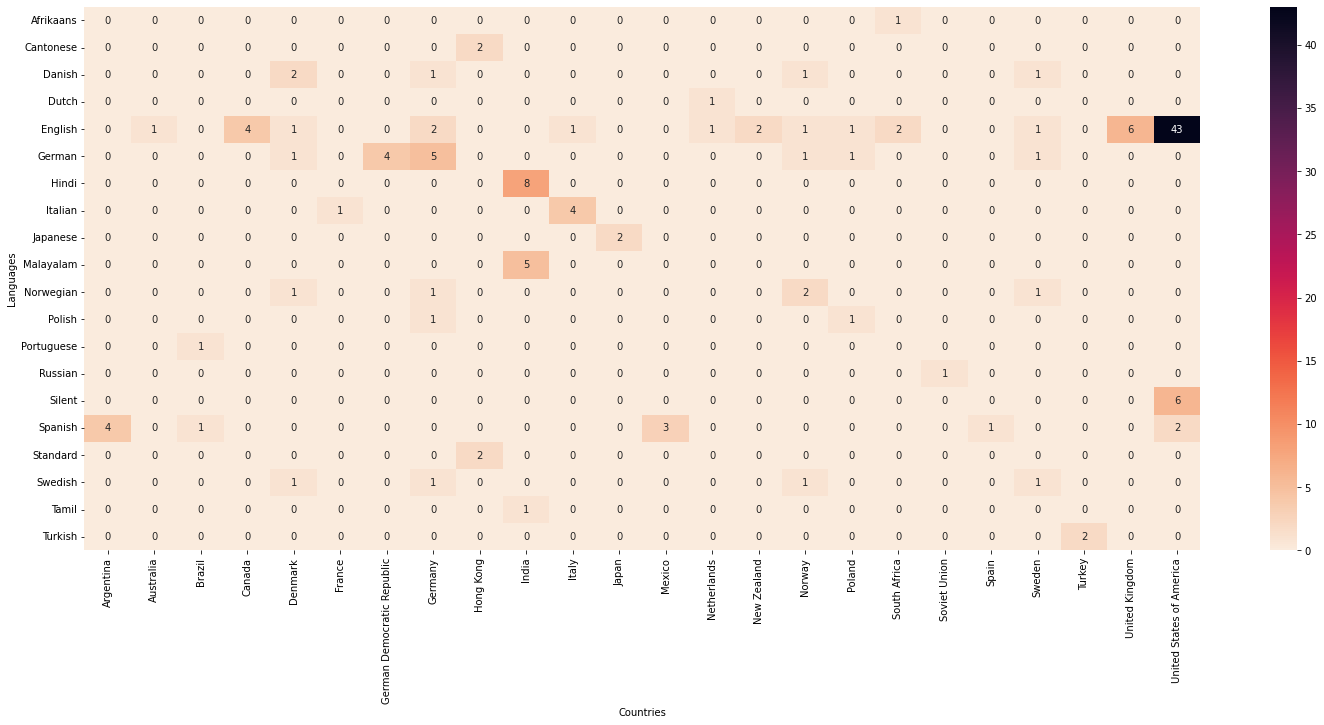

In [95]:
'''Compute the p-value'''
pvalue_language_country = pvalue_var1_var2(df_language_country, 'Languages', 'Countries')

In [96]:
print(f'The p-value for H0: "languages and countries are independent" is {pvalue_language_country}. We deduce that Languages and Countries are not independent variables.')

The p-value for H0: "languages and countries are independent" is 1.6730822642759347e-89. We deduce that Languages and Countries are not independent variables.


#### Languages vs Genres <a class="anchor" id="sub_section_4_2_2"></a>

  Languages             Genres
0   English           Thriller
1   English    Science Fiction
2   English             Horror
3   English          Adventure
4   English       Supernatural
5   English             Action
6   English      Space western
7   English            Mystery
8   English  Biographical film
9   English              Drama


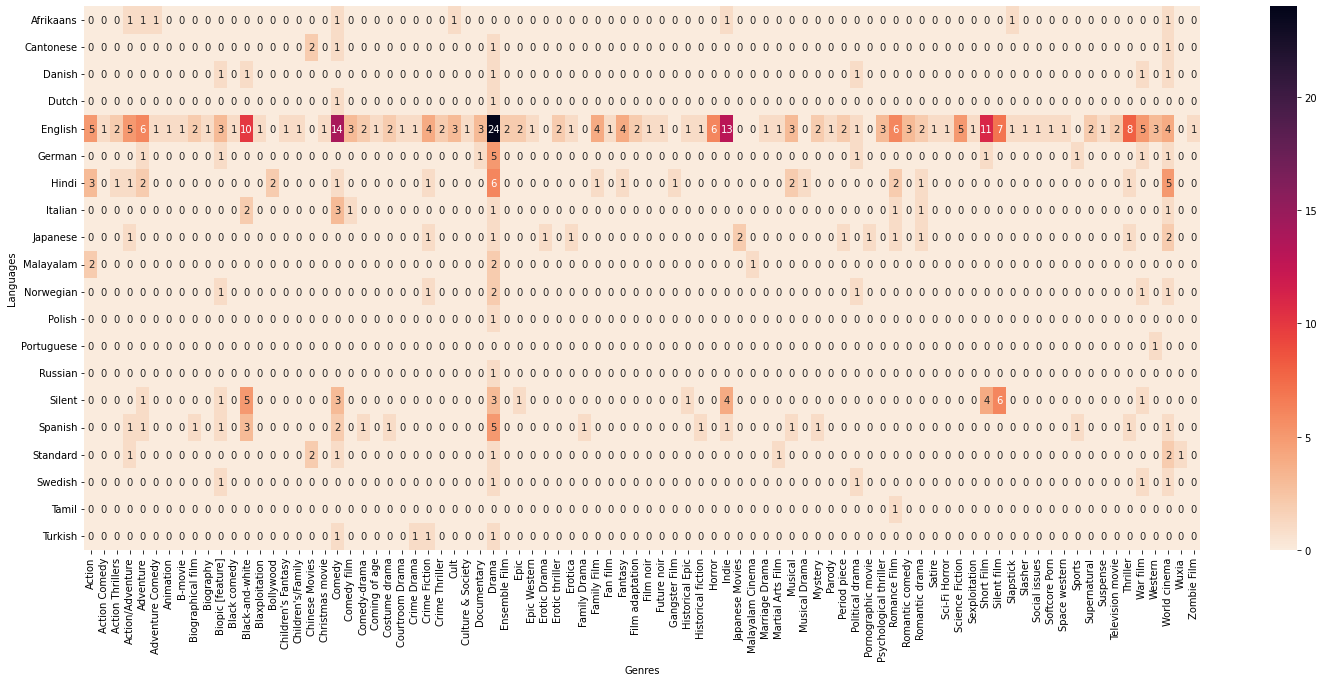

In [97]:
df_language_genre = data_formatting('Languages', 'Genres')
pvalue_language_genre = pvalue_var1_var2(df_language_genre, 'Languages', 'Genres')

In [98]:
print(f'The p-value for H0: "languages and genres are independent" is {pvalue_language_genre}. We deduce that Languages and Genres are independent variables.')

The p-value for H0: "languages and genres are independent" is 0.9999999999999998. We deduce that Languages and Genres are independent variables.


#### Countries vs Genres <a class="anchor" id="sub_section_4_2_3"></a>

                  Countries             Genres
0  United States of America           Thriller
1  United States of America    Science Fiction
2  United States of America             Horror
3  United States of America          Adventure
4  United States of America       Supernatural
5  United States of America             Action
6  United States of America      Space western
7  United States of America            Mystery
8  United States of America  Biographical film
9  United States of America              Drama


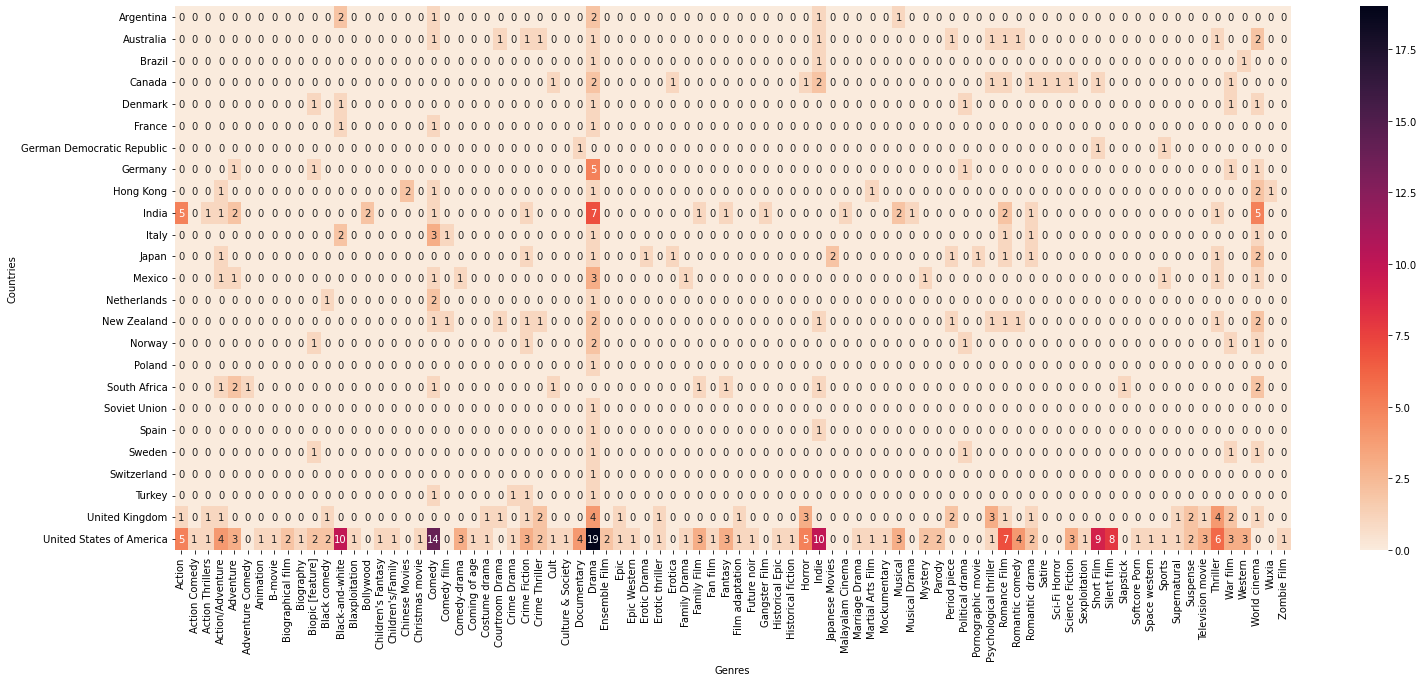

In [99]:
df_country_genre = data_formatting('Countries', 'Genres')
pvalue_country_genre = pvalue_var1_var2(df_country_genre, 'Countries', 'Genres')

In [100]:
print(f'The p-value for H0: "countries and genres are independent" is {pvalue_country_genre}. We deduce that Countries and Genres are independent variables.')

The p-value for H0: "countries and genres are independent" is 1.0. We deduce that Countries and Genres are independent variables.
